<a href="https://colab.research.google.com/github/aplneto/if704-chatbot-project/blob/main/if704_entities_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset

<!-- https://github.com/Tekraj15/Named-Entity-Recognition-Using-LSTM-Keras/blob/master/NER.ipynb
https://towardsdatascience.com/named-entity-recognition-ner-using-keras-bidirectional-lstm-28cd3f301f54 -->

In [1]:
import pandas as pd

In [2]:
TRAIN_DATASET = 'https://raw.githubusercontent.com/awslabs/\
multi-domain-goal-oriented-dialogues-dataset/master/data/paper_splits/\
splits_annotated_at_sentence_level/insurance/train.tsv'

TEST_DATASET = 'https://raw.githubusercontent.com/awslabs/\
multi-domain-goal-oriented-dialogues-dataset/master/data/paper_splits/\
splits_annotated_at_sentence_level/insurance/test.tsv'

DEV_DATASET = 'https://raw.githubusercontent.com/awslabs/\
multi-domain-goal-oriented-dialogues-dataset/master/data/paper_splits/\
splits_annotated_at_sentence_level/insurance/dev.tsv'

train_dataset = pd.read_csv(TRAIN_DATASET, sep='\t')
print(len(train_dataset))
train_dataset = train_dataset.append(pd.read_csv(TEST_DATASET, sep='\t'))
print(len(train_dataset))
train_dataset = train_dataset.append(pd.read_csv(DEV_DATASET, sep='\t'))

train_dataset.head()

14498
18605


,conversationId,turnNumber,sentenceNumber,utteranceId,utterance,slot-labels,intent
0,b668a007-9e23-4e4f-8943-e3000cf27efe,1,0,<CONV>b668a007-9e23-4e4f-8943-e3000cf27efe<TUR...,good evening sir,O O O,openinggreeting
1,b668a007-9e23-4e4f-8943-e3000cf27efe,1,1,<CONV>b668a007-9e23-4e4f-8943-e3000cf27efe<TUR...,i need your help,O O O O,outofdomain
2,b668a007-9e23-4e4f-8943-e3000cf27efe,3,0,<CONV>b668a007-9e23-4e4f-8943-e3000cf27efe<TUR...,4523,ssn,contentonly
3,b668a007-9e23-4e4f-8943-e3000cf27efe,4,0,<CONV>b668a007-9e23-4e4f-8943-e3000cf27efe<TUR...,tamilarasi k,name name,contentonly
4,b668a007-9e23-4e4f-8943-e3000cf27efe,6,0,<CONV>b668a007-9e23-4e4f-8943-e3000cf27efe<TUR...,honda city,car_brand O,contentonly


In [3]:
no_entities = train_dataset[train_dataset['slot-labels'].str.match('^(O\s?)+$')]
train_dataset.drop(no_entities.index, inplace=True)
train_dataset = train_dataset.append(no_entities.sample(frac=0.1))

In [4]:
train_dataset.head()

,conversationId,turnNumber,sentenceNumber,utteranceId,utterance,slot-labels,intent
2,b668a007-9e23-4e4f-8943-e3000cf27efe,3,0,<CONV>b668a007-9e23-4e4f-8943-e3000cf27efe<TUR...,4523,ssn,contentonly
45,b43fdf21-fc2b-404b-9b17-f0cd61124cbe,11,0,<CONV>b43fdf21-fc2b-404b-9b17-f0cd61124cbe<TUR...,amala raghav,name name,contentonly
55,220c5784-6f5e-48c3-9ea4-04296e7aa10a,10,0,<CONV>220c5784-6f5e-48c3-9ea4-04296e7aa10a<TUR...,2014,car_year,contentonly
74,63ffd147-c490-4393-9eaa-78fce15db1d0,6,0,<CONV>63ffd147-c490-4393-9eaa-78fce15db1d0<TUR...,9845264515,phone_number,contentonly
75,63ffd147-c490-4393-9eaa-78fce15db1d0,8,0,<CONV>63ffd147-c490-4393-9eaa-78fce15db1d0<TUR...,mikekank 759 gmailcom,email_address email_address email_address,contentonly


In [5]:
import numpy as np
from itertools import chain

In [6]:
x = list(train_dataset['utterance'])
for i, sentence in enumerate(x):
  if isinstance(sentence, float):
    x[i] = ''

y = train_dataset['slot-labels'].transform(lambda x: x.split(' '))

assert len(x) == len(y)

word_labels = list(np.unique([*chain.from_iterable(y)]))
num_tags = len(word_labels)

In [7]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer

In [8]:
num_tokens = len(x)
biggest_sentence = max(x, key=lambda x: x.split(' ').__len__())
max_len = len(biggest_sentence.split(' '))

labels_y = y.map(lambda x: [word_labels.index(u) for u in x])
labels_y = pad_sequences(
    labels_y, maxlen=max_len, padding='post', value=word_labels.index('O')
)
train_x, test_x, train_y, test_y = train_test_split(x, labels_y, test_size=0.3)

tokenizer = Tokenizer(oov_token="<unk>")
tokenizer.fit_on_texts(train_x)


train_sequences = tokenizer.texts_to_sequences(train_x)
train_sequences = pad_sequences(
    train_sequences, maxlen=max_len, padding='post'
)

test_sequences = tokenizer.texts_to_sequences(test_x)
test_sequences = pad_sequences(
    test_sequences, maxlen=max_len, padding='post'
)

In [9]:
import spacy

In [10]:
nlp = spacy.load('en_core_web_sm')

vocab = [''] + list(tokenizer.word_index.keys())
num_tokens = len(vocab)
vec_dim = len(nlp('the').vector)

embedding_table = np.zeros((num_tokens, vec_dim))


for i, word in enumerate(vocab[1:]):
  embedding_table[i+1] = nlp(word).vector

In [11]:
from tensorflow.keras.layers import Bidirectional, Dense, Embedding, LSTM, \
TimeDistributed, SpatialDropout1D, Flatten
from tensorflow.keras.initializers import Constant
from tensorflow.keras.models import Sequential

In [34]:
model = Sequential()
model.add(
    Embedding(num_tokens, vec_dim, Constant(embedding_table), trainable=False),
)
model.add(SpatialDropout1D(0.1))
model.add(
    Bidirectional(
        LSTM(100, return_sequences=True, recurrent_dropout=0.1)
    )
)
model.add(
    TimeDistributed(
        Dense(num_tags, activation='softmax')
    )
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 96)          323040    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, None, 96)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 200)         157600    
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 10)          2010      
Total params: 482,650
Trainable params: 159,610
Non-trainable params: 323,040
_________________________________________________________________


In [35]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [36]:
from tensorflow.keras.callbacks import EarlyStopping

In [37]:
history = model.fit(
    train_sequences, train_y, batch_size=32, epochs=1,
    callbacks=[EarlyStopping(patience=3, min_delta=0.01)],
    validation_data=[test_sequences, test_y]
)

133/133 [==============================] - 16s 86ms/step - loss: 0.2717 - accuracy: 0.9490 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00


In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

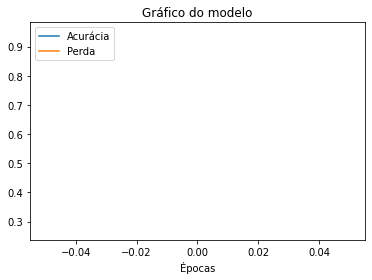

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title("Gráfico do modelo")
plt.xlabel('Épocas')
plt.legend(['Acurácia', 'Perda'], loc='upper left')
plt.show()

In [40]:
model.evaluate(test_sequences, test_y)

57/57 [==============================] - 1s 14ms/step - loss: 0.1399 - accuracy: 0.9657


[0.13987642526626587, 0.9657284617424011]

In [53]:
i = np.random.randint(0, test_sequences.shape[0])
p = model.predict(np.array([test_sequences[i]]))
p = np.argmax(p, -1)
y_true = test_y[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(test_sequences[i], y_true, p[0]):
  print("{:15}{}\t{}".format(vocab[w], word_labels[true], word_labels[pred]))

Word           True 	 Pred

------------------------------
hi             O	O
               O	O
               O	O
               O	O
               O	O
               O	O
               O	O
               O	O
               O	O
               O	O
               O	O
               O	O
               O	O
               O	O
               O	O
               O	O
               O	O
               O	O
               O	O
               O	O


In [68]:
sentence = 'asd 321'
sequence = tokenizer.texts_to_sequences([sentence])
sequence = pad_sequences(sequence, max_len, padding='post')
p = model.predict(sequence)
p = np.argmax(p, -1)
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for x, y in zip(sequence[0], p[0]):
  print("{}\t{}".format(vocab[x], word_labels[y]))

Word           True 	 Pred

------------------------------
asd	claimid
321	claimid
	O
	O
	O
	O
	O
	O
	O
	O
	O
	O
	O
	O
	O
	O
	O
	O
	O
	O


In [43]:
sequence

array([[ 3, 16,  2,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0]], dtype=int32)

In [44]:
class EntityClassifier():
  def __init__(self, tags, model, **kwargs):
    self.__tags = tags
    self.__classifier = model
    self.__tokenizer = kwargs.get('tokenizer')
    self.__vocab = list(self.__tokenizer.word_index.keys())
    self.__max_len = kwargs.get('max_len', 28)
  
  def __call__(self, message):
    sequence = self.__tokenizer.texts_to_sequences([message])
    p = self.__classifier.predict(sequence)
    p = np.argmax(p, -1)
    entities = []
    for x, y in zip(sequence[0], p[0]):
      if x == 0: break
      pair = (self.__vocab[x-1], self.__tags[y])
      entities.append(pair)
    return entities

In [45]:
import datetime
import pickle
import os
import pytz
from google.colab import drive

In [46]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
proj_directory = '/content/drive/MyDrive/chatbot/'
if not os.path.exists(proj_directory):
  os.mkdir(proj_directory)

model_file = proj_directory + 'entity_classifier'
tokenizer_file = proj_directory + 'tokenizer_entity.pickle'
tags_file = proj_directory + 'tags.pickle'
label_encoder_file = proj_directory + 'label_encoder_entities.pickle'

model.save(model_file)
with open(tokenizer_file, 'wb') as _file:
  pickle.dump(tokenizer, _file)

with open(tags_file, 'wb') as _file:
  pickle.dump(word_labels, _file)

timestamp = datetime.datetime.now(pytz.timezone('America/Recife'))
print("Last compiled time:", timestamp)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/chatbot/entity_classifier/assets
Last compiled time: 2021-08-22 16:51:12.698847-03:00
